
##### [Introduction](#intro)

- [Students questions problem and data gathering **(Step 1)**](#prob_desc)
    - [Context](#context)
    - [Content - A quick look at the data](#content)

##### [Methodology ](#method)

- [Accuracy as measure of success **(Step 2)**](#accur)
- [Hold-out evaluation protocol **(Step 3)**](#eval)
- [Preparing the data **(Step 4)**](#data_prep)
- [Code Modularisation](#mod_code)
- [Building a simple TF-IDF model to beat the baseline **(Step 5)**](#base)
- [A LSTM model that overfits the data **(Step 6)**](#overfit)
- [Regularizing the model and tuning the hyperparameters **(Step 7)**](#tune)

##### [Results](#results)
- [ Re-train the model prior to deployment](#retrain)

##### [Discussion/Conclusion](#discussion)

##### [Comparison to the previous coursework](#compare)

##### [References](#ref)


In [1]:
import pandas as pd # dataframe manipulation
import numpy as np # vector manipulation
from tensorflow import keras # neural network library
from tensorflow.keras import layers, regularizers # constructing and regularising neural networks
from nltk.stem import WordNetLemmatizer # Turn words into lemmas
from sklearn.model_selection import train_test_split # data spliting
from sklearn.feature_extraction.text import CountVectorizer # text data vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn import metrics
import nltk # Natural language processing toolset
# from nltk.stem import WordNetLemmatizer # Turn words into lemmas
from sklearn.metrics import confusion_matrix, accuracy_score # Confusion matrix and accuracy
import matplotlib.pyplot as plt # visualisation
import seaborn as sn # Visualisation toolset
import string
import re # regular expressions
import csv # csv toolset
from imblearn.over_sampling import RandomOverSampler # package for dealing with impalanced datasets
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM, Embedding, SimpleRNN, Dense

## Introduction
<a id="intro"></a>

### Students questions problem and data gathering
<a id="prob_desc"></a>

**Context**
<a id="context"></a>


Every year in India numerous students participate in JEE examinations that would give them a chance of being accepted in high-profile Institutes like NITs, AIIMS and IITs. In order to help these students with the examinations and to support them against competition, an Ed Tech industry has been developed. The assistance these companies provide includes mentoring and coaching, both online and offline. The dataset we use for this work includes questions that were asked by students who were preparing for these exams.

The following is a NLP problem where we try to understand which subject this question belongs to based on the description of the question. 

The dataset used for this purspose is available for download on [Kaggle](https://www.kaggle.com/mrutyunjaybiswal/iitjee-neet-aims-students-questions-data).


**Content**
<a id="content"></a>


The dataset (```students-questions```) is in ```.csv``` format and contains a table with two columns.


```eng```: This is the column with the questions or descriptions of the questions provided by students.


```Subject```: The subject each question corresponds to with 4 classes: _Physics, Chemistry, Biology, and Mathematics._


We read in the ```.csv``` file to see if it contains the given descriptions:

In [2]:
# Read csv file
questions = pd.read_csv('subjects-questions.csv')

In [3]:
print (f"As we can see, the dataset has {questions.shape[0]} rows "+
       f"and its column names are: {[col_name for col_name in questions.keys()]}")

As we can see, the dataset has 122519 rows and its column names are: ['eng', 'Subject']


Below we see the first 5 rows of the dataset:

In [4]:
# first 5 rows
questions.head(5)

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


According to frequency table below, Biology is the least frequent appearing category.

In [5]:
# Frequency distribution
questions.Subject.value_counts()

Physics      38438
Chemistry    37767
Maths        33190
Biology      13124
Name: Subject, dtype: int64

Here we can see the distribution of the classes in our dataset which actually plots the information in the above frequency table.

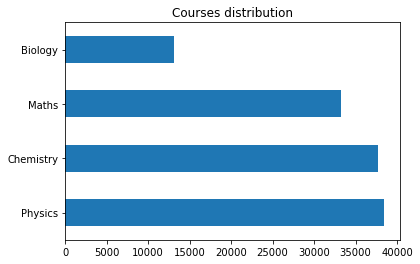

In [5]:
# plotting the data 
questions.Subject.value_counts().plot(kind='barh', title='Courses distribution')
plt.show()

## Methodology
<a id="method"></a>

### Accuracy as measure of success
<a id="accur"></a>  

As a measure of success we will be using accuracy throughout this paper. Accuracy and the area under the ROC curve are measures of success used in practice often with classification problems where the dataset are more or less balanced (when classes have similar frequency counts).

### Hold-out evaluation protocol 
<a id="eval"></a>

A common evaluation protocol used when a sufficient amount of data is available is to keep a hold-out validation set. This technique though can be subject to statistical fluctuation. To ensure the size of the data is suitable for using the hold-out method, we tried at first a simple dense neural network [<sup>**[2]**</sup>](#ref) using different rounds of shuffling when spliting the dataset into the train and validation sets. Taking into acount the fact that the variance in the validation results was not big, hence it would be safe to use this method. These training rounds are not included in this paper.

### Preparing the data
<a id="data_prep"></a>

Here we expose some meaningful information of the dataset using regex (symbols would make sense for mathematics) and remove _a._ , _b._ , _c._ , _d._ and _?_ as we consider it not meaningful.

1. Remove a., b., c., d.

2. Remove stopwords

3. Replace all integers with a common word to retain the information that a number was used but not retain number specific information

4. Build a tokenizer that tokenizes symbols too. This is important information to retain as symbols are used in mathematical operations

In general, neural networks are considered to be less demanding in terms of feature engineering, however here we perform some engineering in order to make the process computationally lighter. 

It is however **important** to note here that we will be passing our ```my_tokenizer``` function to all the vectorisers we will be using as a parameter to make sure that for every case i.e., for the baseline model and LSTM, the same feature engineering will be applied to the data. 

In [6]:
def my_tokeniser(text):
    
    # we remove the integers replacing them with a 
    # single word ('specinteger' is not an actual word but operates as a variable)
    # which contains more meaningful and general infromation for the network to capture
    # instead of having to add too many integers in the vocabulary
    pattern = r"(?<!\.)\d+(?!\.)"
    a = re.sub(pattern , " specinteger ", text)
    
    # similarly we replace floats with a single term ('specifloat')
    pattern = r"[+-]?([0-9]+([.][0-9]*)?|[.][0-9]+)"
    a = re.sub(pattern , " specifloat ", a)
    
    # removing the a. b. c. d. pattern which does not offer useful information
    pattern = r" [AaBbCcDd]\.*? "
    a = re.sub(pattern , " ", a)
    
    # create a space between special characters 
    a = re.sub("(\\W)"," \\1 ",a)
    
    # split based on whitespace
    return re.split("\\s+",a)

### Prepare the train and test data

It is hugely important to treat the test data as completely unseen so that can we prevent any risk of information leakage into the training data. For this purpose we will do our splits before fitting the vectorisers to the data. For the purpose of the simple baseline TFID model we will split the data into the train and test sets. Then we will split the dataset further into train, test and split for training our LSTM model.

In [7]:
# We assign the data to X and y
X = questions.eng
y = questions.Subject

#### Oversampling the Biology class

As we mentioned above, the success measure we will be using, accuracy, works best when applied on a balanced dataset. For this purpose, we will oversample the least frequent classes so that their counts will eventually match those of the largest class, Physics. Random sampling with replacement will be used. The resulting dataset is perfectly balanced and each subject appears exactly 38438 times.


In [8]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='not majority')

In [9]:
# fit and apply the transform
X_over, y_over = oversample.fit_resample(pd.DataFrame(X), pd.DataFrame(y))

In [10]:
# Frequency distribution
y_over.Subject.value_counts()

Biology      38438
Chemistry    38438
Maths        38438
Physics      38438
Name: Subject, dtype: int64

We reassign ```X``` and ```y``` after balancing the classes.

In [11]:
X = X_over.eng
y = y_over.Subject

The ```train_test_split``` method shuffles by default the data during the splitting process. We also set the ```random_state``` parameter of the splitting to 42 for the purpose of outcome reproducibility.

In [12]:
# We split the data keeping 30% as a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(107626,) (46126,) (107626,) (46126,)


### Code modularisation
<a id="mod_code"></a>

In this section we develop a class (```CW_network```) that supports all the methods and attributes of the dense neural networks we will using in this exercise. This will prevent us from rewriting chunks of code and risking obtainind bugs and errors. Moreover, this way with the code being reusable we will be able to tune the model and try different parameters more efficiently. Pieces of the following code are inspired from the book 'Deep Learning with Python' from Francois Chollet[<sup>**[8]**</sup>](#ref)

In [43]:
class CW_network:
    """
        A class to represent model objets in order to facilitate neural network
        training and the visualisation of their results for the purposes of this coursework.

        ...

        Attributes
        ----------
        model : object
            A neural network defined by the user.


        Methods
        -------
        compile_dnn(o, l. m):
            Complies the model with the preffered parameters.
            
        train_dnn( X_train, y_train, X_val, y_val, n_ep, batch):
            Fits and trains the model based on the input data and the 
            preffered paramaters.
            
        evaluation(X_test, y_test):
            Evaluates the model using unseen data.
            
        predictions(X_test):
            Makes predictions about the class of unseed data.
            
        matrix(self, y_test):
            Produces a confusion matrix based on the predictions
            on the unseen data.
            
        vis_matrix(cls):
            Visualises the confustion matrix produced based on the
            predictions.
            
        train_val_loss_graph():
            Visualises the loss of the training and the validation dataset
            for every epoch of the training
          
        train_val_acc_graph():
            Visualises the accuracy of the model ob the training and the 
            validation dataset for every epoch of the training.
                
    """

    def __init__(self, model):
        """
        Constructs all the necessary attributes for the person object.

        Parameters
        ----------
            model : Object
                A dense neural network defined by the user.
            summary : Object
                A summary of the trainable and non-trainable parameters 
                of the model(it displays only if the model is built by the user).

        """
        
        self.model = model
        
        try:
            self.summary = self.model.summary()
        except:
            pass
        
    def compile_network(self, o, l, m):
        """
        It compiles the model with the given parameters.

        Parameters
        ----------
        o : str, optional
            The preffered optimiser for the model
        l : str
            The preffered loss function for the model
        m : str
            The preffered metric for the model
            

        Returns
        -------
        None
        
        """
        
        
        self.model.compile(optimizer=o,
                           loss=l,
                           metrics=[m])
        
    def train_network(self, X_train, y_train, n_ep, batch, val_split ):      
        """
        It trains the model by using the input data.

        Parameters
        ----------
        X_train : array
            The data to be used for training.
        y_train : array
            The labels that correspond to the X_train data.
        X_val : array
            The data to be used for validation.     
        X_val : array
            The data to be used for validation.  
        y_val : array
            The labels that correspond to X_val
        n_ep : int
            Number of epochs for the model to be trained
        batch : int
            Size of the batch of data to be used with each itteration.


        Returns
        -------
        None
        
        """
        
        self.history = self.model.fit(X_train,
                                      y_train,
                                      epochs=n_ep,
                                      batch_size=batch,
                                      validation_split=val_split)
    
    def evaluation(self, X_test, y_test):
                
        """
        It evaluates the model performance on unseed data.

        Parameters
        ----------
        X_test : array
            The preffered optimiser for the model
        y_test : array
            The preffered loss function for the model
        m : str
  

        Returns
        -------
        eval_results : list
            A list with the loss and accuracy of the model.
            eval_results[0] -> loss
            eval_results[1] -> accuracy
        
        """
        
        self.eval_results = self.model.evaluate(X_test, y_test)
        
        return self.eval_results
        
    def predictions(self, X_test):
                        
        """
        It makes predictions by applying the model on unseen data.

        Parameters
        ----------
        X_test : array
            The data to be used for prediction
       
  
        Returns
        -------
        prediction : array
            An array with the probabilities for each class.
        
        """
        
        self.prediction =  self.model.predict(X_test)
        
        return self.prediction
    
    def matrix(self, y_test):
                                
        """
        Produces a confusion matrix based on the predictions
        on the unseen data.

        Parameters
        ----------
        y_test : array
            The labels of the unseen data
       
  
        Returns
        -------
        matrix : array
            An array with the values of the confusion matrix.
        
        """
        
        self.matrix =  confusion_matrix(np.argmax(y_test, axis=1),
                                        np.argmax(self.prediction,axis=1),
                                        normalize='true')
        
        return self.matrix
    
    def vis_matrix(self, cls):
                                
        """
        Visualises the confustion matrix produced based on the
        predictions.

        Parameters
        ----------
        cls : list
            The labels of the data
       
       
        Returns
        -------
        matrix : A matplotlib Object
            A cofusion matrix graph.
        
        """
        
        df_cm = pd.DataFrame(self.matrix,
                             index = [i for i in cls],
                             columns = [i for i in cls])
        
        plt.figure(figsize = (10,8))
        sn.heatmap(df_cm, annot=True, fmt='g')
        plt.show()
    
    def train_val_loss_graph(self):
                                        
        """
        Visualises the loss of the training and the validation dataset
        for every epoch of the training

        """
        # A dictionary that contains the model's metrics during training
        history_dict = self.history.history
        # Loss values of the train set during training
        loss_values = history_dict["loss"]
        # Loss values of validation set during training
        val_loss_values = history_dict["val_loss"]
        # Number of epochs
        epochs = range(1, len(loss_values) + 1)
        # Plotting the training set's loss values
        plt.plot(epochs, loss_values, "bo", label="Training loss")
        # Plotting the validation set's loss values
        plt.plot(epochs, val_loss_values, "b", label="Validation loss")
        # Title of graph
        plt.title("Training and validation loss")
        # Label of x axis
        plt.xlabel("Epochs")
        # Label of y axis
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
    def train_val_acc_graph(self):
                                                
        """
        Visualises the accuracy of the model of the training and the 
        validation dataset for every epoch of the training.

        """
        # A dictionary that contains the model's metrics during training
        history_dict = self.history.history
        # Train set accuracy during training
        acc = history_dict["accuracy"]
        # Validation set accuracy during training
        val_acc = history_dict["val_accuracy"]
        loss_values = history_dict["loss"]
        # Number of epochs
        epochs = range(1, len(loss_values) + 1)
        # Plotting the training set accuracy
        plt.plot(epochs, acc, "bo", label="Training acc")
        # Plotting the validation set accuracy
        plt.plot(epochs, val_acc, "b", label="Validation acc")
        # Title
        plt.title("Training and validation accuracy")
        # Label of x axis
        plt.xlabel("Epochs")
        # Label of y axis
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

To find out more about our objects and its methods and attributes, one can use stardard python syntax over the course of this notebook.

In [44]:
print (CW_network.__doc__)


        A class to represent model objets in order to facilitate the dense neural network
        training and the visualisation of their results for the purposes of this coursework.

        ...

        Attributes
        ----------
        model : object
            A dense neural network defined by the user.


        Methods
        -------
        compile_dnn(o, l. m):
            Complies the model with the preffered parameters.
            
        train_dnn( X_train, y_train, X_val, y_val, n_ep, batch):
            Fits and trains the model based on the input data and the 
            preffered paramaters.
            
        evaluation(X_test, y_test):
            Evaluates the model using unseen data.
            
        predictions(X_test):
            Makes predictions about the class of unseed data.
            
        matrix(self, y_test):
            Produces a confusion matrix based on the predictions
            on the unseen data.
            
        vis_matrix(

One can also use python's help functionality:

In [45]:
# help on 'vis_matrix' method
help(CW_network.vis_matrix)

Help on function vis_matrix in module __main__:

vis_matrix(self, cls)
    Visualises the confustion matrix produced based on the
    predictions.
    
    Parameters
    ----------
    cls : list
        The labels of the data
    
    
    Returns
    -------
    matrix : A matplotlib Object
        A cofusion matrix graph.



### Building a simple model to beat the baseline
<a id="base"></a>

Here we put together the simplest possible model that could be considered and improvement to the most naive algorithm i.e., the random selector. We expect that this model will have a higher accuracy than the random selector, which is expected to be accurate 25% of the time. It is possibile that this model could perform reasonably well, however we intend to further enhance it with a more complex model that could capture more patterns in the data in order to improve performance. 

### Baseline performance
<a id="baseline"></a>

As mentioned previously, we will be using a Naive Bayes[<sup>**[6]**</sup>](#ref) classifier as a baseline algorithm that we can later compare out results to. To be more specific we will be using a multinomial Naive Bayes model as the target variable has more than 2 classes. This algorithm uses Bays' theorem assuming independence of the different features i.e., zero correlation. This kind of classifier is widely used in NLP problems because of its scalablility potential.

#### Term Frequency and Inverse Document Frequency (TF-IDF)
<a id="tfidf"></a>

TF-IDF is a metric that determines if a term is significant to a text.

We can finally fit the TF-IDF vectoriser to the train dataset (please **note** here that we won't be using the test data at this stage, since this could imply information leakage. We will treat the test data as totally unseen.)

In [17]:
# We define our tf-idf vectoriser
tf_idf = TfidfVectorizer(min_df=0, lowercase=True,
                        # we use 'my_tokeniser' function
                        tokenizer=my_tokeniser,
                        # we remove all the English stop words
                        stop_words='english')

# We fit the vectoriser to the the train data
X_train_vectorised = tf_idf.fit_transform(X_train)

# We transform the train data
X_train_vectorised = tf_idf.transform(X_train)

In [18]:
print(f"A sample of the sparse matrix :\n\n{X_train_vectorised[0]}")

print (f"\n\nThe matrix contains {X_train_vectorised.shape[0]} number of samples and {X_train_vectorised.shape[1]} number of features")

A sample of the sparse matrix :

  (0, 32674)	0.1594227694789056
  (0, 32672)	0.15941749381369308
  (0, 31924)	0.063622515417768
  (0, 27420)	0.24544430277378593
  (0, 27414)	0.32910839035873707
  (0, 27257)	0.14398184490404806
  (0, 27177)	0.09218266700999003
  (0, 23264)	0.21832137759937204
  (0, 21949)	0.10379315366038516
  (0, 21075)	0.058286347087017236
  (0, 20196)	0.11524564571666994
  (0, 18684)	0.31408036965025743
  (0, 18670)	0.12343602102140691
  (0, 17818)	0.19017025639537652
  (0, 17424)	0.10152533936744347
  (0, 15960)	0.09254267098976784
  (0, 13058)	0.0659028610044336
  (0, 13057)	0.05629378218481926
  (0, 8928)	0.1317913689777758
  (0, 8517)	0.14026061441589582
  (0, 7351)	0.020488797611057884
  (0, 4670)	0.03857932401288416
  (0, 3881)	0.24124012293810312
  (0, 2573)	0.021674644085500697
  (0, 310)	0.07259201035146498
  (0, 262)	0.10881187992375088
  (0, 260)	0.12615935639628453
  (0, 24)	0.5149116865563251
  (0, 21)	0.03800160676728249
  (0, 14)	0.08783534760091898
 

In [19]:
X_test_vectorised = tf_idf.transform(X_test)

#### Naive Bayes Classifier
<a id="nb"></a>

Here we define our Naive Bayes classifier:

In [20]:
# We define our Naive Bayes classifier
naive_bayes_clf = MultinomialNB()

We then fit this classifier to the TF-IDF vectorised train data.

In [21]:
# We fit the classifier to the tf-idf vectorised train data
naive_bayes_clf.fit(X_train_vectorised, y_train)

MultinomialNB()

We can now use our classifier to predict the classes in the test dataset.

In [22]:
y_predicted = naive_bayes_clf.predict(X_test_vectorised)

Finally, we produce the report below that shows how the baseline classifier performed with regards predicting the classes of the unseen data.

In [23]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

     Biology       0.94      0.92      0.93     11580
   Chemistry       0.90      0.86      0.88     11417
       Maths       0.90      0.95      0.92     11552
     Physics       0.89      0.89      0.89     11577

    accuracy                           0.91     46126
   macro avg       0.91      0.91      0.91     46126
weighted avg       0.91      0.91      0.91     46126



In [24]:
accuracy_score(y_test, y_predicted)

0.9067120496032607



The accuracy of the baseline classifier is 91% as seen in the report above. Overall precision, recall and f1-score are also at 91%. There is little to almost no variation in the class-specific precision scores.


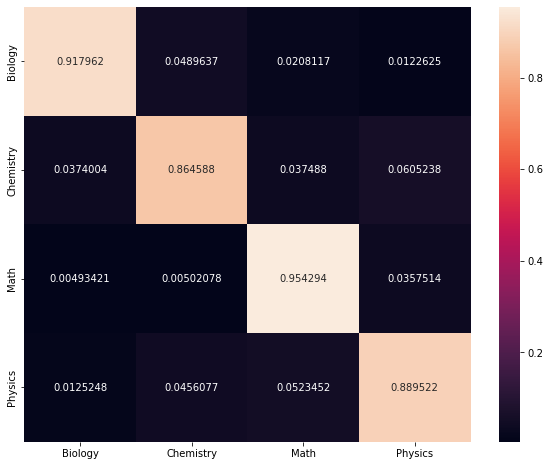

In [25]:
# Generating the confusion matrix

mat = metrics.confusion_matrix(y_test, y_predicted, normalize='true')

df_cm = pd.DataFrame(mat,
                     index = ["Biology", "Chemistry", 
                              "Math", "Physics"],
                     columns = ["Biology", "Chemistry", 
                              "Math", "Physics"])

plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

We have plotted a heatmap plot which results from calculating the confusion matrix for this classification. This heatmap basically plots the class-level accuracy scores i.e., all combinations of correct and incorrect classifications expressed as a percentage. The true positive levels are relatively high ranging from 86% for Chemistry to 95% for Math.

### Vectorising the data for the neural network models

In order to help us represent our text data as vectors we will use the ```CountVectorizer``` from sklearn[<sup>**[3]**</sup>](#ref). This method converts a collection of text documents to a matrix of token counts. We initiate the count vectoriser so we can later fit it to the train dataset.

In [26]:
# We initiate vectoriser for X
vec_X = CountVectorizer(min_df=0, lowercase=True,
                        # we use 'my_tokeniser' function
                        tokenizer=my_tokeniser,
                        # we remove all the English stop words
                        stop_words='english',
                        # our output is a vector that only contains 0, 1
                        binary = True)

In [27]:
# Similarly we initiate vectoriser for y
vec_y = CountVectorizer()

Word embeddings are a category of word representation that permit words to have matching representations if they have matching meanings[<sup>**[4]**</sup>](#ref). A key benefit of using word embeddings over sparse word representations is that they result in words being represented in much fewer dimensions therefore indirectly adding benefit to speed, space usage etc. The words' usage indicates how the representation is learnt, something that contrasts to for example a 'bag of words' approach where words will be represented differently even if they have meanings that are alike. Below we create a helper function to fit the vectoriser to our training dataset.


In [29]:
# We create a helper function for fitting our vectoriser by using train data
# and later gerenate the embeddings 
def pre_proc_text(train_text, text, vectoriser):
    # we fit our vectoriser to the data
    vectoriser.fit(train_text)
    # transform our data to array
    text_vect = vectoriser.transform(text).toarray()
    # We use the indices of the elements of our sparce vectors that are non-zero 
    return np.array([list(np.nonzero(i)[0]) for i in text_vect], dtype=object)   

It is now of major **importance** to only use the _train_ data to fit the vectoriser. Then we can use the ```vec_X``` and ```vec_y``` vectorisers to transform the validation and test data into arrays respectively.

In [30]:
# We transfrom our train data to vector 
# by fitting vec_X to the train data
X_train_vect = pre_proc_text(X_train, X_train, vec_X)
print (X_train_vect.shape)

/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(107626,)


In [31]:
print (f"A vocabulary of {len(vec_X.vocabulary_)} words has been created")

A vocabulary of 33148 words has been created


Similarly for the test data

In [32]:
# We transfrom our test data to vector
X_test_vect = pre_proc_text(X_train, X_test, vec_X)
print (X_test_vect.shape)

(46126,)


We can now vectorise the labels

In [33]:
vec_y.fit(y_train)

CountVectorizer()

In [34]:
y_train_vect = vec_y.transform(y_train).toarray()
print (y_train_vect.shape)

(107626, 4)


In [35]:
y_test_vect = vec_y.transform(y_test).toarray()
print (y_test_vect.shape)

(46126, 4)


In [36]:
# The maximum of words for our word embeddings
max_len= 45
# we are padding the sequences
X_train_vect = sequence.pad_sequences(X_train_vect, maxlen=max_len)
X_test_vect = sequence.pad_sequences(X_test_vect, maxlen=max_len)

Using TensorFlow backend.


### A LSTM model that overfits the data
<a id="overfit"></a>

Here we develop a more complicated model that will overfit the data. The number of parameters in this model is so large so that so that a great deal of information only specific to the training data is captured. This becomes noticeable after a few epochs when the loss in the validation set starts increasing from the 4th epoch onwards.

In [145]:
# model definition

model = Sequential()
model.add(Embedding(len(vec_X.vocabulary_), 128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(4, activation="softmax"))

In [142]:
model_x = CW_network(model)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 45, 128)           4242944   
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 260       
Total params: 4,292,612
Trainable params: 4,292,612
Non-trainable params: 0
_________________________________________________________________


In [146]:
# Model compilation
model_x.compile_network("rmsprop", "categorical_crossentropy", "accuracy")

In [147]:
model_x.train_network(X_train_vect, y_train_vect, 10, 1024, .3)

/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 75338 samples, validate on 32288 samples
Epoch 1/10
75338/75338 [==============================] - 224s 3ms/step - loss: 0.1764 - accuracy: 0.9442 - val_loss: 0.1809 - val_accuracy: 0.9403
Epoch 2/10
75338/75338 [==============================] - 78s 1ms/step - loss: 0.1313 - accuracy: 0.9566 - val_loss: 0.1686 - val_accuracy: 0.9429
Epoch 3/10
75338/75338 [==============================] - 77s 1ms/step - loss: 0.1098 - accuracy: 0.9634 - val_loss: 0.1663 - val_accuracy: 0.9426
Epoch 4/10
75338/75338 [==============================] - 76s 1ms/step - loss: 0.0973 - accuracy: 0.9668 - val_loss: 0.1555 - val_accuracy: 0.9486
Epoch 5/10
75338/75338 [==============================] - 74s 984us/step - loss: 0.0864 - accuracy: 0.9694 - val_loss: 0.1625 - val_accuracy: 0.9467
Epoch 6/10
75338/75338 [==============================] - 90s 1ms/step - loss: 0.0790 - accuracy: 0.9722 - val_loss: 0.1609 - val_accuracy: 0.9488
Epoch 7/10
75338/75338 [==============================] - 78s 1ms

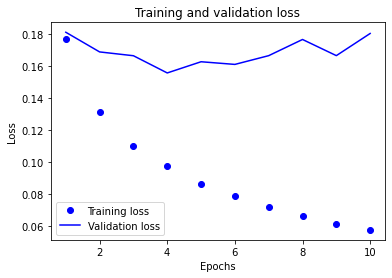

In [199]:
# training vs validation loss graph
model_x.train_val_loss_graph()

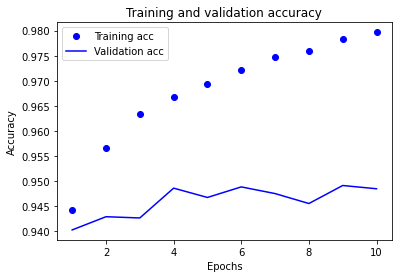

In [149]:
# training vs validation accuracy graph
model_x.train_val_acc_graph()

We see here that as epochs increase, accuracy increases drastically. Despite that, the training process demonstrated that the model started overfitting sfter the 4th epoch. We can further fine-tune our model to optimise the accuracy and generalisability levels at the same time.

### Regularizing the model and tuning the hyperparameters
<a id="tune"></a>


Here we attempt to regularise the model and tune the hyperparameters to achieve a higher accuracy than that of the simple model applied at first, however at the same time we will try to avoid overfitting the training data. 

In this case we won't be using the dropout regularisation technique because we will actually try to achieve the same result by restricting the number of the parameters for the neural network.

Our aim is to find an appropriate set of hyperparameters. The model's hyperparameters are defined as all non-trainable parameters such as the number of layers and nodes in layers, the model's learning rate etc. We will attempt to tune the hyperparameters between the train and the validation sets as we want to prevent information from leaking between the unseen test data and the training data during the fine-tuning process.

After careful examination and experimentations, the presentation of which is out of scope for this paper, we decided to regularise our model by going through the following steps:

- We introduced a dropout of 0.2 after the first layer. This way the number of the neurons were randomly removed hence simplifying our model and preventing overfitting.

- For the second layer of the network we applied L2 regularisation.

- We introduced a learning rate schedule that has a polynomial decay[<sup>**[5]**</sup>](#ref) shape. In our scenario we observed that a monotonically decreasing learning rate improved the model's performance. Using this method, a polynomial decay function was applied to the model's steps. To carry out optimisation the user has to experiment and select the ```initial_learning_rate```, the ```end_learning_rate``` and the step of the schedule.

- Last but not least, we tried a few other activators (```tanh```, ```sigmoid```) and optimisation functions (```adam```) however we figured out that ```relu```, ```softmax``` and ```RMSprop``` provided better results in this exercise. 


In [155]:
# model definition

model = Sequential()
model.add(Embedding(len(vec_X.vocabulary_), 128, input_length=max_len))
model.add(LSTM(32, dropout=0.2, kernel_regularizer = regularizers.l2(0.001), activation="relu"))

model.add(Dense(4, activation="softmax"))

In [156]:
model_x1 = CW_network(model)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 45, 128)           4242944   
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 132       
Total params: 4,263,684
Trainable params: 4,263,684
Non-trainable params: 0
_________________________________________________________________


In [154]:
starter_learning_rate = 0.001
end_learning_rate = 0.00005
decay_steps = 1000
lr_schedule = keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.)
rmsprop = keras.optimizers.RMSprop(lr_schedule)

In [157]:
# Model compilation
model_x1.compile_network(rmsprop, "categorical_crossentropy", "accuracy")

In [158]:
model_x1.train_network(X_train_vect, y_train_vect, 10, 1024, .3)

Train on 75338 samples, validate on 32288 samples
Epoch 1/10
75338/75338 [==============================] - 39s 512us/step - loss: 1.0392 - accuracy: 0.7192 - val_loss: 0.5232 - val_accuracy: 0.8582
Epoch 2/10
75338/75338 [==============================] - 36s 484us/step - loss: 0.4541 - accuracy: 0.8931 - val_loss: 0.3564 - val_accuracy: 0.9104
Epoch 3/10
75338/75338 [==============================] - 39s 516us/step - loss: 0.3181 - accuracy: 0.9281 - val_loss: 0.2728 - val_accuracy: 0.9329
Epoch 4/10
75338/75338 [==============================] - 38s 506us/step - loss: 0.2510 - accuracy: 0.9410 - val_loss: 0.2454 - val_accuracy: 0.9367
Epoch 5/10
75338/75338 [==============================] - 37s 496us/step - loss: 0.2122 - accuracy: 0.9482 - val_loss: 0.2677 - val_accuracy: 0.9364
Epoch 6/10
75338/75338 [==============================] - 38s 505us/step - loss: 0.1870 - accuracy: 0.9534 - val_loss: 0.2158 - val_accuracy: 0.9406
Epoch 7/10
75338/75338 [==============================] 

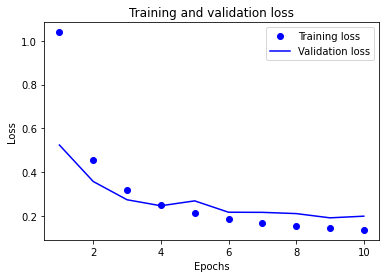

In [159]:
# training vs validation loss graph
model_x1.train_val_loss_graph()

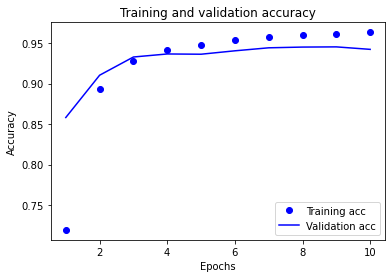

In [160]:
# training vs validation accuracy graph
model_x1.train_val_acc_graph()

In [178]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 45, 128)           4242944   
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 132       
Total params: 4,263,684
Trainable params: 4,263,684
Non-trainable params: 0
_________________________________________________________________


From the above outputs we can see that this model is performing much better than the previous one. The validation loss continues to drop but the rate decreases after around the 5th epoch. Validation accuracy also becomes steady after the 3rd epoch. We could have carried on running the model for more epochs to keep the loss keeps decreasing, this could though result to the model overfitting the validation dataset which we would prefer to avoid.

## Results
<a id="results"></a>


Below we can see the model evaluation outputs. The overall accuracy levels are looking very promising at approximately 95%. The overall loss is approximately 0.2. The class-specific accuracy matrix indicates that the results look as expected. The elements in the diagonal are coloured brightly, something that demonstrates hight accuracy ranging from 91% to 99%. The elements off the diagonal that show the percentage of wrongly classified questions have darker colours. The worst mis-classification accuracy value is observed between _physics_ and _biology_, where our network mistakes these two courses (and vice versa, since a similarly high score is observed either side of the diagonal). This happens though 4-5% of the time , which could possibly be considered as lying within acceptable levels for this kind of classification problems (for problems where e.g. the task would be to assign patients to a certain drug dose category, misclassification rates would possibly need to be lower).

In [162]:
results = model_x1.evaluation(X_test_vect, y_test_vect)

46126/46126 [==============================] - 34s 727us/step


In [163]:
print (f"loss: {results[0]}\naccuracy: {results[1]}")

loss: 0.20483010877829155
accuracy: 0.9446299076080322


In [164]:
model_x1.predictions(X_test_vect)

array([[5.7519581e-05, 1.6139373e-03, 9.9748421e-01, 8.4423856e-04],
       [1.2025371e-15, 1.0470218e-09, 9.9998534e-01, 1.4702440e-05],
       [9.9998128e-01, 1.1047907e-05, 6.7980159e-06, 8.9544079e-07],
       ...,
       [7.8216410e-04, 2.0535273e-02, 9.6346360e-01, 1.5218975e-02],
       [5.1611772e-07, 6.4046466e-04, 4.9543264e-04, 9.9886358e-01],
       [1.0222477e-01, 6.9144255e-01, 7.6283496e-03, 1.9870430e-01]],
      dtype=float32)

In [165]:
model_x1.matrix(y_test_vect)

array([[0.96476684, 0.02340242, 0.00785838, 0.00397237],
       [0.02566348, 0.92090742, 0.01164929, 0.0417798 ],
       [0.00138504, 0.0037223 , 0.98485111, 0.01004155],
       [0.00734214, 0.05044485, 0.03446489, 0.90774812]])

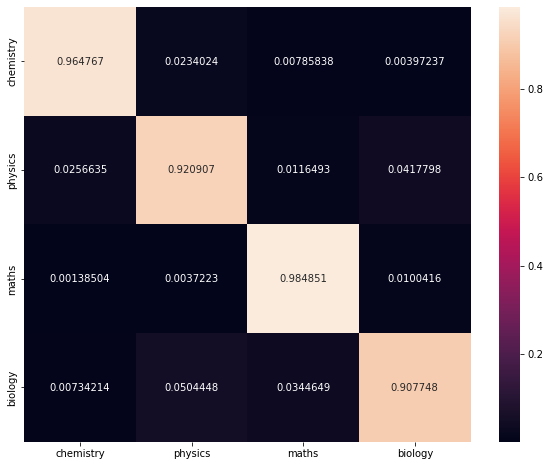

In [166]:
model_x1.vis_matrix(vec_y.vocabulary_.keys())

### Re-train the model prior to deployment
<a id="retrain"></a>

Finally when we have agreed the final form for our model, we merge the train and test data and re-train the model. This is often done in practice before deploying models during the cycle of data product development. The re-trained model cannot be evaluated though in terms of performance measures, since the whole dataset have been used during model training hence no unseen data for performing the testing on exists anymore.

#### Prepare the data to run the model 

Here we prepare the data in order to train the model based on the whole dataset ```X``` and ```y```.

In [167]:
# We use X to generate X_train_final
X_train_final = pre_proc_text(X_train, X, vec_X)

/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [192]:
X_train_final = sequence.pad_sequences(X_train_final, maxlen=max_len)

In [170]:
# we use y to generate y_train_final
y_train_final = vec_y.transform(y).toarray()

In [185]:
model_final = CW_network(model)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 45, 128)           4242944   
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 132       
Total params: 4,263,684
Trainable params: 4,263,684
Non-trainable params: 0
_________________________________________________________________


In [186]:
# We implement the predicided rmprop strategy
starter_learning_rate = 0.001
end_learning_rate = 0.00005
decay_steps = 1000
lr_schedule = keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.)
rmsprop = keras.optimizers.RMSprop(lr_schedule)

In [187]:
# Model compilation
model_final.compile_network(rmsprop, "categorical_crossentropy", "accuracy")

From the previus experimentation we have identified that 9 is the optimal number of epochs.

In [193]:
model_final.train_network(X_train_final, y_train_final, 9, 1024, val_split=0.0)

Epoch 1/9
153752/153752 [==============================] - 104s 679us/step - loss: 0.1829 - accuracy: 0.9504
Epoch 2/9
153752/153752 [==============================] - 101s 659us/step - loss: 0.1506 - accuracy: 0.9569
Epoch 3/9
153752/153752 [==============================] - 106s 690us/step - loss: 0.1355 - accuracy: 0.9598
Epoch 4/9
153752/153752 [==============================] - 102s 665us/step - loss: 0.1248 - accuracy: 0.9627
Epoch 5/9
153752/153752 [==============================] - 103s 668us/step - loss: 0.1161 - accuracy: 0.9645
Epoch 6/9
153752/153752 [==============================] - 100s 648us/step - loss: 0.1107 - accuracy: 0.9658
Epoch 7/9
153752/153752 [==============================] - 99s 644us/step - loss: 0.1063 - accuracy: 0.9669
Epoch 8/9
153752/153752 [==============================] - 101s 660us/step - loss: 0.1054 - accuracy: 0.9673
Epoch 9/9
153752/153752 [==============================] - 101s 656us/step - loss: 0.1046 - accuracy: 0.9675


We do not evaulate now as we have used all the available data for the predeploymet training. We were expecting that the accuracy would be slightly higher that 94.4 as for the pre deployment training we used all the data available. 

## Discussion/Conclusion
<a id="discussion"></a>

In this report we attempted to apply neural networks on a natural language processing (NLP) problem. The text data we used for this purpose comprised of questions that were asked by Indian students preparing for the exams required to get accepted to a university. The dataset consisted of approximately than 123000 questions, with each question having been assigned the subject it belongs to. The 4 subjects included in the data were biology, physics, maths and chemistry. Our intent was to develop a neural network model to predict with some acceptable level of accuracy the subject each question corresponds to given the question's content.

It's worth noting at this stage that model performance can be affected strongly with an increasing sample size when classes are imbalanced in terms of size[<sup>**[6]**</sup>](#ref). For this purpose and as a data preparation step, we decided to balance out the difference in size between classes using a common approach, oversampling[<sup>**[7]**</sup>](#ref). We used random sampling with replacement in order to equate the size of all classes to that of the most frequent one, Physics.

The first step of this analysis was to apply a Naive Bayes classifier which we used as a baseline approach so that we could  benchmark our results later in the process. We chose accuracy as performance measure. For the baseline algorithm the accuracy was around 91%. We carried on our analysis with applying to the data a very complicated LSTM model that overfitted the training set, which is commonly done in practice. We saw a quick boost in accuracy levels; nevertheless, validation loss also started increasing too after a number of epochs. This in fact indicated the point at which the network began overfitting the data. 

Lastly, we fitted a regularised LSTM model in order to tune the network's hyperparameters. The regularised model performed remarkably well, with an overall accuracy of 95% approximately. Within-class accuracy scores ranged between 91% and 99% and mis-classification took place infrequently, which looked rather encouraging. 

Finally, we trained the final model once again on the merged training and validation data. This approach is frequently done in practice before deploying models when building data products, since it is considered to actually help boost a model's generalisability. Models that result from such a re-training process cannot however be assessed in terms of model performance, since no unseen data exists to test the models on.

## References
<a id="ref"></a>



[1] [Ministry of Education - Government of India. Joint Entrance Examination (Main)](https://jeemain.nta.nic.in/webinfo2021/Page/Page?PageId=1&LangId=P)

[2] Hopfield, J. J. (1982). "Neural networks and physical systems with emergent collective computational abilities". Proc. Natl. Acad. Sci. U.S.A. 79 (8): 2554–2558

[3] [Feature extraction - sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

[4] Jurafsky, Daniel; H. James, Martin (2000). Speech and language processing : an introduction to natural language processing, computational linguistics, and speech recognition. Upper Saddle River, N.J.: Prentice Hall. ISBN 978-0-13-095069-7.

[5] [Learning rage optimiser - Keras](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay)

[6] ["Classification of Imbalanced Data:Review of Methods and Applications", Pradeep Kumar et al 2021 IOP Conf. Ser.: Mater. Sci. Eng. 1099 012077](https://iopscience.iop.org/article/10.1088/1757-899X/1099/1/012077/pdf)

[7] [Classification on imbalanced data - Tensorflow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

[8] [Deep Learining with Python - Manning publications](https://www.manning.com/books/deep-learning-with-python)

